# Tutorial

This run-through tutorial is intended to display a variety of methods for combining datasets using the `kerchunk.combine.MultiZarrtoZarr` API.

Initially we create a pair of single file jsons for two ERA5 variables using `Kerchunk.hdf.SingleHdf5ToZarr`. This ERA5 dataset is free to access and so it is possible to replicate this workflow on a local machine without credentials.

## Single file JSONs

The ``Kerchunk.hdf.SingleHdf5ToZarr`` method is used to create a single ``.json`` reference file for each file url passed to it. Here we use it to create a number of reference files for the ERA5 pubic dataset on [AWS](https://registry.opendata.aws/ecmwf-era5/). We will compute a number of different times and variables to demonstrate different methods of combining them.

The Kerchunk package is still in a devolpment phase and so changes frequently. Installing directly from the source code is recommended. 

In [1]:
# !pip install git+https://github.com/fsspec/kerchunk

Here we are considering Netcdf4 files and so use the kerchunk `hdf` module. Support for `fits`, `grib2`, `tiff`, `netCDF3` and `zarr` are available in other kerchunk modules. Alternatively it is also possible to manually create reference jsons for more specific cases. The Earth Big Data [example](https://github.com/fsspec/kerchunk/blob/main/examples/earthbigdata.ipynb) provides a demonstration of this.

In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
import fsspec

Using fsspec to create a pythonic filesystem, provides a convenient way to manage file urls.

In [3]:
fs = fsspec.filesystem('s3', anon=True) #S3 file system to manage ERA5 files
flist = (fs.glob('s3://era5-pds/2020/*/data/air_pressure_at_mean_sea_level.nc')[:2]
        + fs.glob('s3://era5-pds/2020/*/data/*sea_surface_temperature.nc')[:2])

In [4]:
fs2 = fsspec.filesystem('')  #local file system to save final jsons to

In [5]:
from pathlib import Path
import os
import ujson

so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first') # args to fs.open()
# default_fill_cache=False avoids caching data in between file chunks to lowers memory usage.

def gen_json(file):
    with fs.open(file, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, file, inline_threshold=300) 
        # inline threshold adjusts the Size below which binary blocks are included directly in the output
        # a higher inline threshold can result in a larger json file but faster loading time
        variable = file.split('/')[-1].split('.')[0]
        month = file.split('/')[2] 
        outf = f'{month}_{variable}.json' #file name to save json to
        with fs2.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

ERA5-pds is located in us-west-2 and so depending on where this computation is taking place the time taken can vary dramatically and is likely to be faster than this.

In [6]:
%%time
for file in flist:
    gen_json(file)

CPU times: user 7.66 s, sys: 1.74 s, total: 9.4 s
Wall time: 1min 25s


The `.json` reference files we have generated can now be used to open virtual datasets through xarray. To achieve this it is first neccessary to create a mapping of the reference file using `fsspec`. Here specifying that the reference json is pointing to files stored on AWS.

In [7]:
import xarray as xr

In [8]:
%%time
fs_ = fsspec.filesystem("reference", fo='01_air_pressure_at_mean_sea_level.json', ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='s3', remote_options={'anon':True})
m = fs_.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
print(ds)

<xarray.Dataset>
Dimensions:                         (time0: 744, lat: 721, lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 nan 0.25 0.5 ... 359.5 359.8
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (time0, lat, lon) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts
CPU times: user 136 ms, sys: 23 ms, total: 159 ms
Wall time: 426 ms


## Combine multiple kerchunk'd datasets into a single logical aggregate dataset

The `Kerchunk.combine.MultiZarrtoZarr` method combines the `.json` reference files generated above to create a single virtual dataset, such that one reference file maps to all of the chunks in the individual files.

In [9]:
from kerchunk.combine import MultiZarrToZarr

MultiZarrtoZarr provides a number of convenience methods to combine reference files. The simplest is to concatenate along a specified dimension using the `concat_dims` argument, Time0 in this instance. Specifying the identical coordinate across the files using the `identical_dims` argument is not strictly neccessary but will speed up computation times.

In [10]:
json_list = fs2.glob("*_air_pressure_at_mean_sea_level.json")

mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon'])

d = mzz.translate()

with fs2.open('air_pressure_at_mean_sea_level_combined.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())

The reference json we have just generated can now be opened to reveal a single virtual dataset spanning both the input files, with little to no latency.

In [11]:
%%time
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                         (time0: 1440, lat: 721, lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 nan 0.25 0.5 ... 359.5 359.8
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts
CPU times: user 28.8 ms, sys: 3.18 ms, total: 31.9 ms
Wall time: 31.1 ms


### Using coo_map

When the dimension along which we would like to concatenate is not already in the dataset, or when considering datasets from across an ensemble we can use the ``coo_map`` argument to create a new dimension.

In [12]:
new_dims = ['a' , 'b']

mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'new_dimension':new_dims},
    concat_dims=['new_dimension'],
    identical_dims = ['lat', 'lon']
)

d = mzz.translate()

In [13]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                         (new_dimension: 2, time0: 744, lat: 721,
                                     lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 nan 0.25 0.5 ... 359.5 359.8
  * new_dimension                   (new_dimension) object 'a' 'b'
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (new_dimension, time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


For more complex uses it is also possible to pass in a compiled `regex` function which operates on the input file url's to generate a unique variable for each file.

In [14]:
import re
ex = re.compile(r'.*(\d+)_air')

In [15]:
ex.match(json_list[0]).groups()[0]

'1'

In [16]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {'new_dimension':ex},
    concat_dims=['new_dimension'],
    identical_dims = ['lat', 'lon']
)

d = mzz.translate()

In [17]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                         (new_dimension: 2, time0: 744, lat: 721,
                                     lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 nan 0.25 0.5 ... 359.5 359.8
  * new_dimension                   (new_dimension) object '1' '2'
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (new_dimension, time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


Similarly we can map each file to a new variable using the special `var` character in coo_map. Here we use the same `regex` function but instead map these as new variables.

In [18]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {"var":ex},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon']
)

d = mzz.translate()

In [19]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:  (time0: 1440, lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 nan 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-02-29T23:00:00
Data variables:
    1        (time0, lat, lon) float32 ...
    2        (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


Another special character in `coo_map` is `attr:`. This allows the user to access variables from the file attributes.

In [20]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {"var":"attr:institution"},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon']
)

d = mzz.translate()

In [21]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:  (time0: 1440, lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 nan 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-02-29T23:00:00
Data variables:
    ECMWF    (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


The special charactar ``vattr:{var}:`` allows access to variable attributes. Here renaming the variable to instead use it’s short name. 

There are a number of other special characters for ``coo_map`` documented in the [API reference](https://fsspec.github.io/kerchunk/reference.html#kerchunk.combine.MultiZarrToZarr)

In [22]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    coo_map = {"var":"vattr:air_pressure_at_mean_sea_level:shortNameECMWF"},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon']
)

d = mzz.translate()

In [23]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time0: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 nan 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time0    (time0) datetime64[ns] 2020-01-01 ... 2020-02-29T23:00:00
Data variables:
    msl      (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


### Merging variables across jsons

The `Kerchunk.combine.merge_vars` convenienve function can be used to merge variables across datasets if we know the coordinates and global file attributes are identical. 

In [24]:
from kerchunk.combine import merge_vars

json_list = fs2.glob("01_sea_surface_temperature.json") + fs2.glob("01_air_pressure_at_mean_sea_level.json")

d = merge_vars(json_list)

m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                         (time0: 744, lat: 721, lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 nan 0.25 0.5 ... 359.5 359.8
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (time0, lat, lon) float32 ...
    sea_surface_temperature         (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


### Preprocessing

Pre-process can be used to apply arbitrary functions to the refs item in the input jsons before combining. In this case we use preprocessing to drop the `air_pressure_at_mean_sea_level` variable before combining `sea_surface_temperature` with a json containing data for the following month.

In [25]:
def pre_process(refs):
    for k in list(refs):
        if k.startswith('air_pressure_at_mean_sea_level'):
            refs.pop(k)
    return refs

In [26]:
json_list = fs2.glob("vars_combined.json") + fs2.glob("02_sea_surface_temperature.json")

In [27]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon'],
    preprocess = pre_process)

d = mzz.translate()

In [28]:
with fs2.open('sea_surface_temperature_combined.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())

In [29]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                  (lat: 721, lon: 1440, time0: 696)
Coordinates:
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                      (lon) float32 nan 0.25 0.5 ... 359.2 359.5 359.8
  * time0                    (time0) datetime64[ns] 2020-02-01 ... 2020-02-29...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


### Postprocessing

Similarly post-process can be used to apply an arbitrary function to the final dictionary before returning.
A known issue with this partcular dataset is that no fill value has been assigned to the lat and lon coordinates and thus default to 0, here we use post process to change the zarr fill_value attribute by opening the final json as a zarr store. 

Changing the fill_values could also be achieved by editing the final json through string manipulations or even a simple find and replace through an IDE.

In [30]:
import zarr
def modify_fill_value(out):
    out_ = zarr.open(out)
    out_.lon.fill_value = -999
    out_.lat.fill_value = -999
    return out

def postprocess(out):
    out = modify_fill_value(out)
    return out

In [31]:
json_list = fs2.glob("air_pressure_at_mean_sea_level_combined.json") + fs2.glob("sea_surface_temperature_combined.json")

mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['time0'],
    identical_dims = ['lat', 'lon'],
    postprocess = postprocess)

d = mzz.translate()

In [32]:
with fs2.open('combined.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())

In [33]:
m = fsspec.filesystem("reference", fo=d).get_mapper("")
ds = xr.open_dataset(m, engine="zarr", consolidated=False)
print(ds)

<xarray.Dataset>
Dimensions:                         (time0: 1440, lat: 721, lon: 1440)
Coordinates:
  * lat                             (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                             (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * time0                           (time0) datetime64[ns] 2020-01-01 ... 202...
Data variables:
    air_pressure_at_mean_sea_level  (time0, lat, lon) float32 ...
    sea_surface_temperature         (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


## Using the output

To open a previously computed referenced dataset it is not neccessary to have kerchunk installed. Only `fsspec` to generate the file mapping 

Here we open a remotely stored reference file that maps to 10 ERA5 variables across a 43 year time span

The sidecar file has been compressed using zstd, from the original 1.8GB to 194MB. Opening this virtual dataset requires 7GB of free system memory. 

A smaller file containing only 2 years of data is available at: s3://esip-qhub-public/ecmwf/ERA5_2020_2022_multivar.json.zst

In [34]:
%%time
fs = fsspec.filesystem("reference", fo='s3://esip-qhub-public/ecmwf/ERA5_1979_2022_multivar.json.zst', 
                       ref_storage_args={"compression": "zstd"},
                       remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False})
print(ds)

<xarray.Dataset>
Dimensions:                               (time0: 380568, lat: 721, lon: 1440)
Coordinates:
  * lat                                   (lat) float32 90.0 89.75 ... -90.0
  * lon                                   (lon) float32 0.0 0.25 ... 359.5 359.8
  * time0                                 (time0) datetime64[ns] 1979-01-01 ....
Data variables:
    air_pressure_at_mean_sea_level        (time0, lat, lon) float32 ...
    air_temperature_at_2_metres           (time0, lat, lon) float32 ...
    dew_point_temperature_at_2_metres     (time0, lat, lon) float32 ...
    eastward_wind_at_100_metres           (time0, lat, lon) float32 ...
    eastward_wind_at_10_metres            (time0, lat, lon) float32 ...
    lwe_thickness_of_surface_snow_amount  (time0, lat, lon) float32 ...
    northward_wind_at_100_metres          (time0, lat, lon) float32 ...
    sea_surface_temperature               (time0, lat, lon) float32 ...
Attributes:
    institution:  ECMWF
    source:       Reanal

CPU times: user 1.52 s, sys: 106 ms, total: 1.62 s
Wall time: 14.9 s


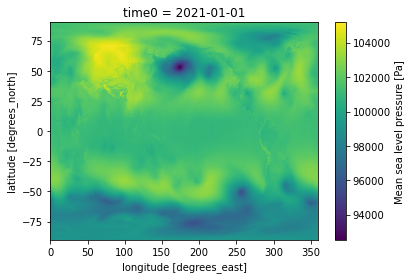

In [35]:
%%time
da = ds.sel(time0 = '2021-01-01T00:00:00')
da['air_pressure_at_mean_sea_level'].plot()

CPU times: user 2.38 s, sys: 184 ms, total: 2.56 s
Wall time: 58.1 s


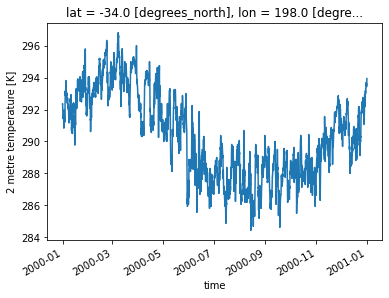

In [47]:
%%time
da = ds.sel(lat = -34).sel(lon = 198)
da.air_temperature_at_2_metres.sel(time0 = slice('2000-01-01','2000-12-31')).plot()